In [2]:
import torch
from torch import nn
from sklearn.datasets import make_moons

# Make 1000 samples 
n_samples = 1000

# Create circles
X, y = make_moons(n_samples,
                    noise=0.03, # a little bit of noise to the dots
                    random_state=42) # keep random state so we get the same values

print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

First 5 X features:
[[-0.00933187  0.39098105]
 [ 0.95457387 -0.47375583]
 [ 0.9185256  -0.42519648]
 [ 0.41276802 -0.37638459]
 [-0.84532016  0.52879908]]

First 5 y labels:
[1 1 1 1 0]


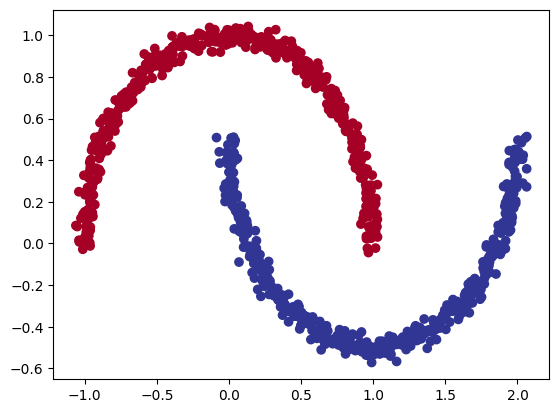

In [3]:
# Visualize with a plot
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0], 
            y=X[:, 1], 
            c=y, 
            cmap=plt.cm.RdYlBu);

In [4]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [36]:
# Standard PyTorch imports
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

class MoonModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2,out_features=10)
        self.layer_2 = nn.Linear(in_features=10,out_features=10)
        self.layer_3 = nn.Linear(in_features=10,out_features=10)
        self.layer_4 = nn.Linear(in_features=10,out_features=1)
        self.relu = nn.ReLU()

    def forward(self,x):
        # Return the output of layer_2, a single feature, the same shape as y
       return self.layer_4(self.relu(self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))))
model_0 = MoonModelV0().to(device)
model_0


MoonModelV0(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=10, bias=True)
  (layer_4): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [37]:
#loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_0.parameters(),lr=0.1)

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [39]:
# Fit the model
torch.manual_seed(42)
epochs = 1000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels
    
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_0(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calcuate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.00019, Accuracy: 100.00% | Test Loss: 0.00021, Test Accuracy: 100.00%
Epoch: 100 | Loss: 0.00019, Accuracy: 100.00% | Test Loss: 0.00021, Test Accuracy: 100.00%
Epoch: 200 | Loss: 0.00018, Accuracy: 100.00% | Test Loss: 0.00020, Test Accuracy: 100.00%
Epoch: 300 | Loss: 0.00018, Accuracy: 100.00% | Test Loss: 0.00020, Test Accuracy: 100.00%
Epoch: 400 | Loss: 0.00018, Accuracy: 100.00% | Test Loss: 0.00019, Test Accuracy: 100.00%
Epoch: 500 | Loss: 0.00017, Accuracy: 100.00% | Test Loss: 0.00019, Test Accuracy: 100.00%
Epoch: 600 | Loss: 0.00017, Accuracy: 100.00% | Test Loss: 0.00019, Test Accuracy: 100.00%
Epoch: 700 | Loss: 0.00016, Accuracy: 100.00% | Test Loss: 0.00018, Test Accuracy: 100.00%
Epoch: 800 | Loss: 0.00016, Accuracy: 100.00% | Test Loss: 0.00018, Test Accuracy: 100.00%
Epoch: 900 | Loss: 0.00016, Accuracy: 100.00% | Test Loss: 0.00017, Test Accuracy: 100.00%


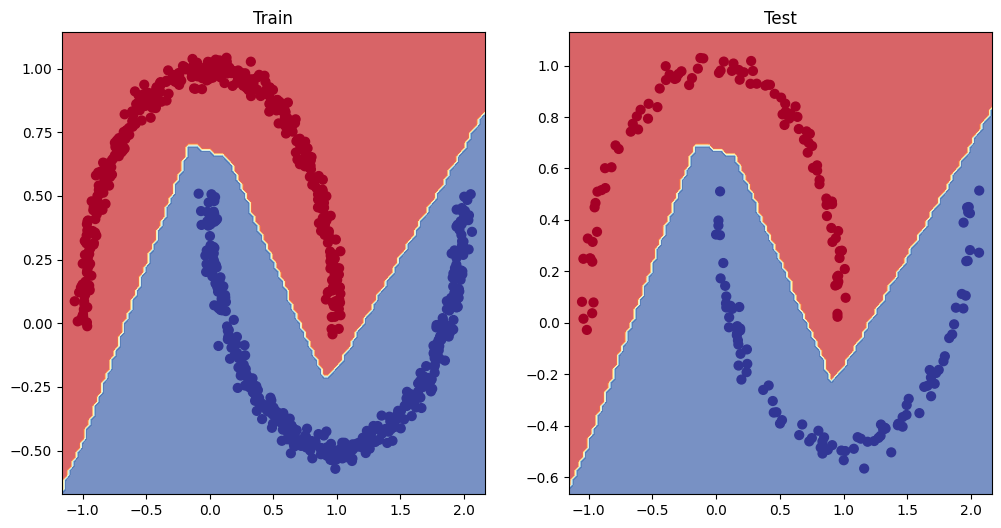

In [40]:
from helper_functions import plot_predictions, plot_decision_boundary
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test) # model_3 = has non-linearity